## 1. Set up the experiment


Zero-shot superresolution of the `GNO` model: From `(16, 16)` grid to `(64, 64)` grid.

### 1-1. Import modules

In [1]:
import  os, time
from    pathlib             import  Path
from    tqdm.notebook       import  tqdm
import  pickle
import  matplotlib.pyplot   as      plt

import  numpy                       as  np
import  torch
from    torch                       import  nn
from    torch_geometric.data        import  Data
from    torch_geometric.loader      import  DataLoader

import  yaml

from    custom_modules.utils                import  GaussianNormalizer, npzReader
from    custom_modules.utils                import  GridGenerator
from    custom_modules.pytorch.neuralop     import  GNOLite
from    custom_modules.pytorch.torch_utils  import  count_parameters

### 1-2. Load the configurations

In [2]:
with open("config_test.yaml") as f:
    config = yaml.load(f, Loader = yaml.FullLoader)
    _exp   = config['experiment']
    _data  = config['pde_dataset']
    _graph = config['graph']
    _gno   = config['gno']
    train_prefix = config['train_prefix']

### 1-3. Set the experiment

In [3]:
# NOTE Training and data preprocess


BATCH_SIZE      = _exp['batch_size']
TEST_SIZE       = _exp['test_size']
DEVICE          = torch.device(f"cuda:{_exp['cuda_index']}")


RESOLUTION      = _data['resolution']
TEST_PATH       = Path(_data['path'])
TEST_MASK       = np.random.choice(1024, TEST_SIZE, replace = False)


DOWNSAMPLE      = _data['downsample']
GRID            = (RESOLUTION - 1) // DOWNSAMPLE + 1
NUM_NODES       = GRID ** 2


RADIUS_TRAIN    = _graph['radius']

In [4]:
### NOTE Model instantiation
def get_path(train_grid: int) -> str:
    return f"{train_prefix}/gnolite_darcy{RESOLUTION}_res{train_grid}"


gno = GNOLite(**_gno)
gno.load_state_dict(torch.load(f"{get_path(16)}.pth"))
gno.to(DEVICE)

print(f"The number of the parameters in the custom GNO\n>>> {count_parameters(gno)}")
print(gno)

The number of the parameters in the custom GNO
>>> 155265
GraphNeuralOperatorLite(
    lift:       MLP(layer=(6, 64, 32), bias=True, activation=relu),
    hidden:     GraphKernelLayer(node_dim=32, kernel_layer=MLP(layer=(6, 128, 128, 1024), bias=True, activation=relu))
                x 6)
                )
    projection: MLP(layer=(32, 64, 1), bias=True, activation=relu),
)


### * Report the train history

Custom model    : 143.98 seconds


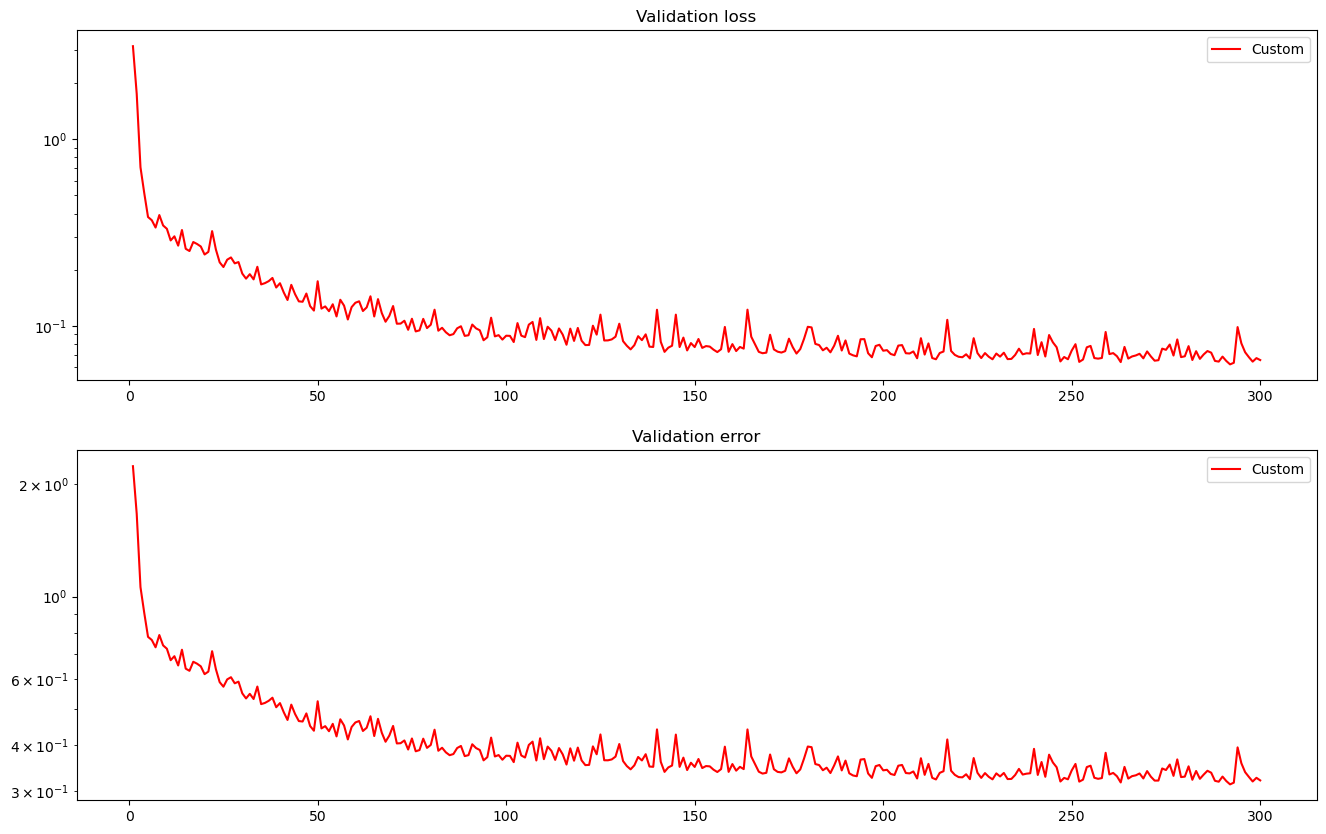

In [5]:
# Train history
with open(f"{get_path(16)}.pickle", "rb") as f:
    custom_train_history = pickle.load(f)

# Number of epochs
NUM_TRAIN_EPOCHS = len(custom_train_history['train_loss'])
_epoch_list = np.arange(NUM_TRAIN_EPOCHS) + 1

# Training time
print(f"Custom model    : {custom_train_history['train_time']:.2f} seconds")


# Plot
fig, axes = plt.subplots(2, 1, figsize = (16, 10))
axes[0].plot(_epoch_list, custom_train_history['val_loss'], c = 'r', label = "Custom")
axes[0].set_title("Validation loss")
axes[0].set_yscale("log")
axes[0].legend()
axes[1].plot(_epoch_list, custom_train_history['val_error'], c = 'r', label = "Custom")
axes[1].set_title("Validation error")
axes[1].set_yscale("log")
axes[1].legend()
plt.show()

## 2. Preprocess data

### 2-1. Instantiate the storages

In [6]:
test_data: dict[str, torch.Tensor]= {
    'coeff':    None,
    'Kcoeff':   None,
    'Kcoeff_x': None,
    'Kcoeff_y': None,
    'sol':      None,
}


# Normalizers
normalizer = torch.load(f"{get_path(16)}_normalizer.pth")

### 2-2. Load the train data

In [7]:
# Test data
reader = npzReader(TEST_PATH)
for cnt, k in tqdm(enumerate(test_data.keys()), desc = "Preprocessing the test data"):
    # Step 1. Load data
    test_data[k] = torch.from_numpy(reader.get_field(k))
    test_data[k] = test_data[k][-TEST_SIZE:, ::DOWNSAMPLE, ::DOWNSAMPLE].flatten(-1)
    test_data[k] = test_data[k].type(torch.float)
    
    # Step 2. Normalize data (NOTE: Uses the normalizers for the train dataset)
    test_data[k] = normalizer[k].encode(test_data[k])

Preprocessing the test data: 0it [00:00, ?it/s]

### 2-3. Construct graphs

In [8]:
# NOTE Generate a grid to set the node and edge attributes


grid_generator  = GridGenerator([[0., 1.], [0., 1.]], [GRID, GRID], radius = 0.1)
grid_full_info = grid_generator.full_information()
node_index  = grid_full_info['node_index']
edge_index  = grid_full_info['edge_index']
grid        = grid_full_info['grid']

In [9]:
# NOTE Construct graphs


list_test_data = []


for idx in tqdm(range(TEST_SIZE)):
    _coeff      = test_data[ 'coeff'  ][idx].reshape(NUM_NODES, -1)
    _Kcoeff     = test_data[ 'Kcoeff' ][idx].reshape(NUM_NODES, -1)
    _Kcoeff_x   = test_data['Kcoeff_x'][idx].reshape(NUM_NODES, -1)
    _Kcoeff_y   = test_data['Kcoeff_y'][idx].reshape(NUM_NODES, -1)
    # Define the node feature
    _x = torch.hstack([grid, _coeff, _Kcoeff, _Kcoeff_x, _Kcoeff_y])
    # Define the node target
    _y = test_data['sol'][idx].reshape(NUM_NODES, -1)
    # Define the edge feature
    _edge_attr = torch.hstack(
        [
            grid[edge_index[0]],
            grid[edge_index[1]],
            _coeff[edge_index[0]],
            _coeff[edge_index[1]]
        ]
    )
    
    # Append the new graph
    list_test_data.append(
        Data(
            x = _x,
            y = _y,
            edge_index  = edge_index,
            edge_attr   = _edge_attr,
        )
    )
    del(_coeff, _Kcoeff, _Kcoeff_x, _Kcoeff_y, _x, _y, _edge_attr)

  0%|          | 0/50 [00:00<?, ?it/s]

### 2-4. Instantiate dataloaders

In [10]:
test_loader  = DataLoader(list_test_data,  batch_size = BATCH_SIZE, shuffle = True)

## 3. Test the model

### 3-1. Initialize the loss function

In [11]:
criterion = nn.MSELoss(reduction = 'mean')

### 3-2. Test the model

In [12]:
normalizer['sol'].to(DEVICE)


# NOTE: Test
gno.eval()
with torch.no_grad():
    elapsed_time = time.time()

    test_epoch_loss:    torch.Tensor = 0
    test_epoch_error:   torch.Tensor = 0
    for batch in tqdm(test_loader, desc = "Test"):
        batch: Data = batch.to(DEVICE)
        
        test_pred = gno.forward(batch.x, batch.edge_index, batch.edge_attr)
        test_loss = criterion.forward(test_pred, batch.y)
        
        test_epoch_loss     = test_epoch_loss + test_loss * len(batch)
        test_pred   = normalizer['sol'].decode(test_pred)
        batch.y     = normalizer['sol'].decode(batch.y)
        test_epoch_error    = test_epoch_error + (
                                    torch.linalg.norm(test_pred - batch.y) / (1e-8 + torch.linalg.norm(batch.y))
                                ) * len(batch)
    test_epoch_loss     = test_epoch_loss / TEST_SIZE
    test_epoch_error    = test_epoch_error / TEST_SIZE
elapsed_time = time.time() - elapsed_time

print(f"* Elapsed time: {int(elapsed_time)} seconds")
print(f"* Test loss:    {test_epoch_loss.item():.4e}")
print(f"* L^2 error:    {test_epoch_error.item():.4e}")

Test:   0%|          | 0/13 [00:00<?, ?it/s]

* Elapsed time: 7 seconds
* Test loss:    2.9698e-02
* L^2 error:    1.0517e-01


### 3-3. Plot some examples

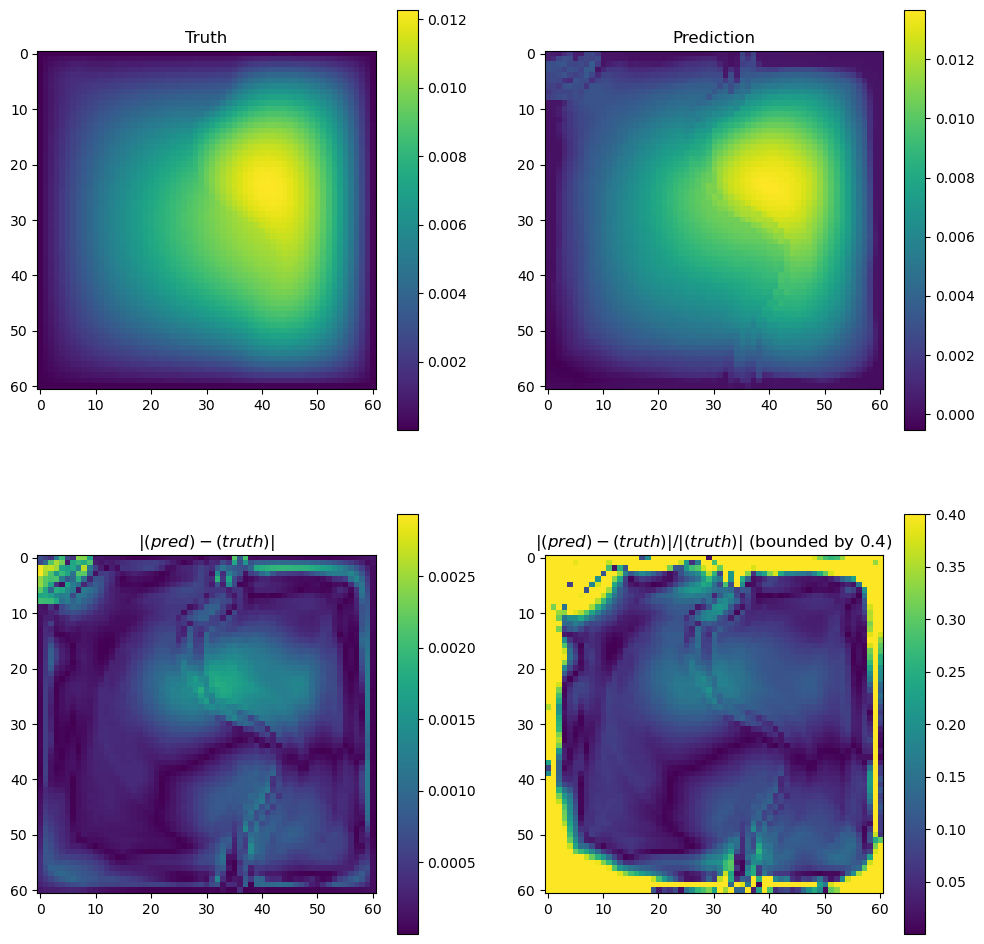

In [13]:
example_range = slice(0, GRID**2)
fig, axes = plt.subplots(2, 2, figsize = (12, 12))
example_y    = batch.y[example_range].reshape(GRID, GRID).cpu()
example_pred = test_pred[0: GRID**2].reshape(GRID, GRID).cpu()

im = axes[0, 0].imshow(example_y)
axes[0, 0].set_title("Truth")
plt.colorbar(im, ax = axes[0, 0])

im = axes[0, 1].imshow(example_pred)
axes[0, 1].set_title("Prediction")
plt.colorbar(im, ax = axes[0, 1])

im = axes[1, 0].imshow((example_pred - example_y).abs())
axes[1, 0].set_title("$|(pred) - (truth)|$")
plt.colorbar(im, ax = axes[1, 0])

_vmax = 0.4
im = axes[1, 1].imshow((example_pred - example_y).abs() / example_y.abs(), vmax = _vmax)
axes[1, 1].set_title(f"$|(pred) - (truth)| / |(truth)|$ (bounded by {_vmax})")
plt.colorbar(im, ax = axes[1, 1])

plt.show()

## End of file